In [2]:
import pandas as pd
from fbprophet.plot import plot_plotly
from fbprophet import Prophet
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.sans-serif']=['SimHei']
#plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

In [13]:
data=pd.read_csv(r'C:\Users\飘哥\Desktop\地铁od数据\研究线路每小时进站总客流.csv',usecols=['FDT_HOUR','FINT_COUNT'])
data.columns=['ds','y']
data.ds=pd.to_datetime(data.ds)
data



,ds,y
0,2020-06-29 05:00:00,215
1,2020-06-29 06:00:00,1622
2,2020-06-29 07:00:00,4805
3,2020-06-29 08:00:00,6529
4,2020-06-29 09:00:00,2993
...,...,...
553,2020-07-29 18:00:00,1655
554,2020-07-29 19:00:00,859
555,2020-07-29 20:00:00,624
556,2020-07-29 21:00:00,454


In [14]:
rain=pd.read_csv(r'C:\Users\飘哥\Desktop\rain\rain.csv')
rain.columns=['ds','rain']
rain.ds=pd.to_datetime(rain.ds)
data2=pd.merge(data,rain,on='ds',how='left')
#分训练集和测试集
# data_train=data2[:396]
# data_test=data2[396:]

In [155]:
#数据归一化和取log
#df['y'] = (df['y'] - df['y'].mean()) / (df['y'].std())
# import numpy as np
# df.y=np.log(df.y)
# df

In [123]:
#数据选择
#df2=df.copy()
#df2.ds=pd.to_datetime(df2.ds)
#df2=df2[(df2.ds.dt.weekday<=4)&(df2.ds.dt.hour<=22)&(df2.ds.dt.hour>=5)]
#df2

In [15]:
m = Prophet(changepoint_prior_scale=0.05,daily_seasonality=10,changepoint_range=0.8,seasonality_mode='additive')
#m.add_country_holidays(country_name='CN')
m.add_regressor('rain',prior_scale=0.5, mode='multiplicative')
m.fit(data2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [16]:
#预测时长，D是天 216
future = m.make_future_dataframe(periods=144,freq='h')
future.tail()

,ds
697,2020-08-04 18:00:00
698,2020-08-04 19:00:00
699,2020-08-04 20:00:00
700,2020-08-04 21:00:00
701,2020-08-04 22:00:00


In [17]:
#预测日期修改为有规则间隔的数据,如果数据仅为工作日,future对应调整
future2=future.copy()
future2=future2[(future2.ds.dt.hour<=22)&(future2.ds.dt.hour>=5)]

future2=pd.merge(future2,rain,on='ds',how='left')
future2

,ds,rain
0,2020-06-29 05:00:00,0.666667
1,2020-06-29 06:00:00,4.666667
2,2020-06-29 07:00:00,8.333333
3,2020-06-29 08:00:00,0.416667
4,2020-06-29 09:00:00,0.500000
...,...,...
661,2020-08-04 18:00:00,0.000000
662,2020-08-04 19:00:00,0.000000
663,2020-08-04 20:00:00,0.000000
664,2020-08-04 21:00:00,0.000000


In [18]:
forecast = m.predict(future2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-06-29 05:00:00,279.227817,-583.154206,1125.754214
1,2020-06-29 06:00:00,1386.487472,617.963822,2232.562218
2,2020-06-29 07:00:00,4313.881778,3473.495906,5195.582417
3,2020-06-29 08:00:00,5280.271744,4412.551852,6112.008042
4,2020-06-29 09:00:00,2662.304628,1850.371327,3452.617635


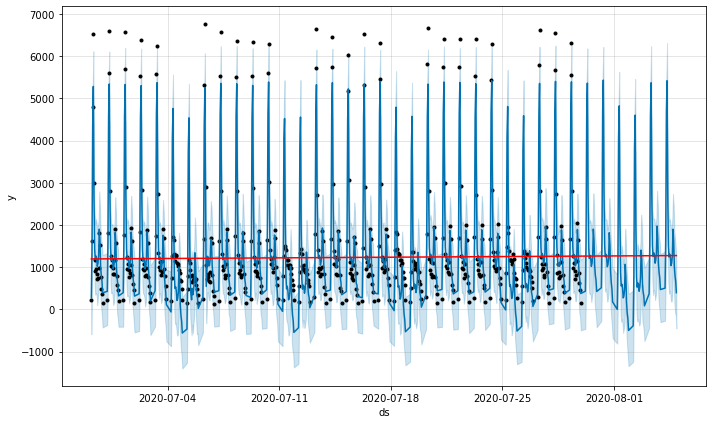

In [19]:
# 突变点
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [137]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper',
       'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'rain',
       'rain_lower', 'rain_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yhat'],
      dtype='object')

Text(0.5, 0, 'ds')

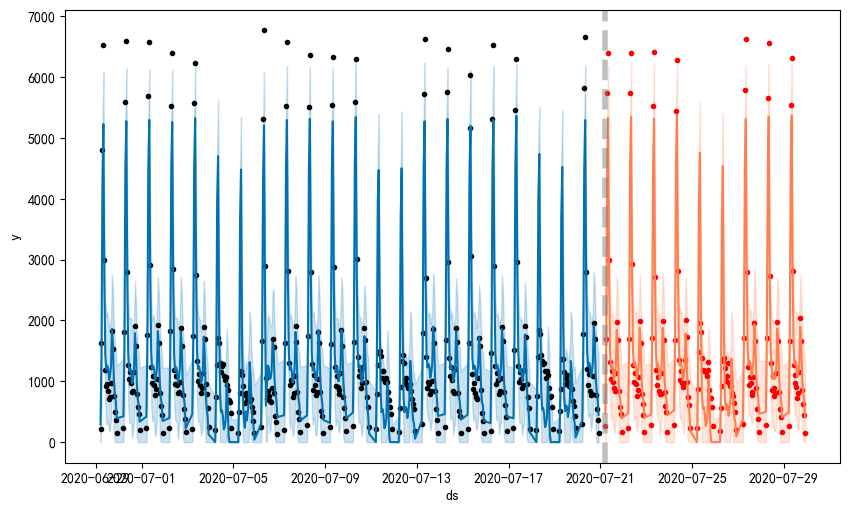

In [134]:
#训练和测试
fig,ax=plt.subplots(figsize=(10,6),facecolor='w',dpi=100)
ax.plot(data_train['ds'].values, data_train['y'], 'k.')
ax.plot(data_test['ds'].values, data_test['y'], 'r.')
ax.plot(forecast['ds'][:396], forecast['yhat'][:396].clip(lower=0), ls='-', c='#0072B2')
ax.plot(forecast['ds'][396:], forecast['yhat'][396:].clip(lower=0), ls='-', c='#FF7F50')
ax.fill_between(forecast['ds'][:396], forecast['yhat_upper'][:396],forecast['yhat_lower'][:396].clip(lower=0),color='#0072B2',alpha=0.2)
ax.fill_between(forecast['ds'][396:], forecast['yhat_upper'][396:],forecast['yhat_lower'][396:].clip(lower=0),color='#FF7F50',alpha=0.2)
ax.axvline(x=pd.to_datetime('2020-07-21 05:00:00'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.set_ylabel('y')
ax.set_xlabel('ds')

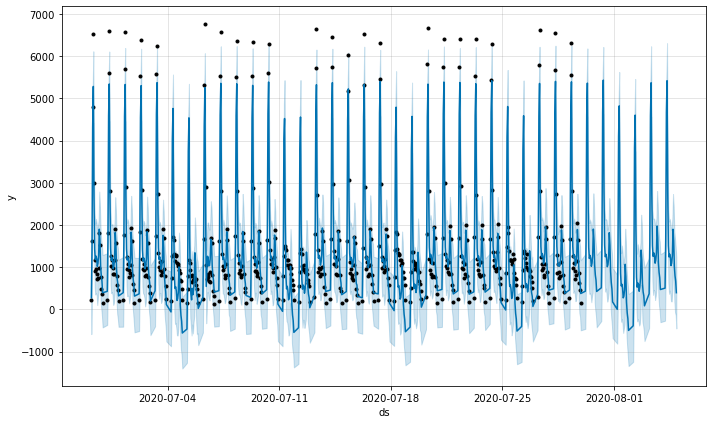

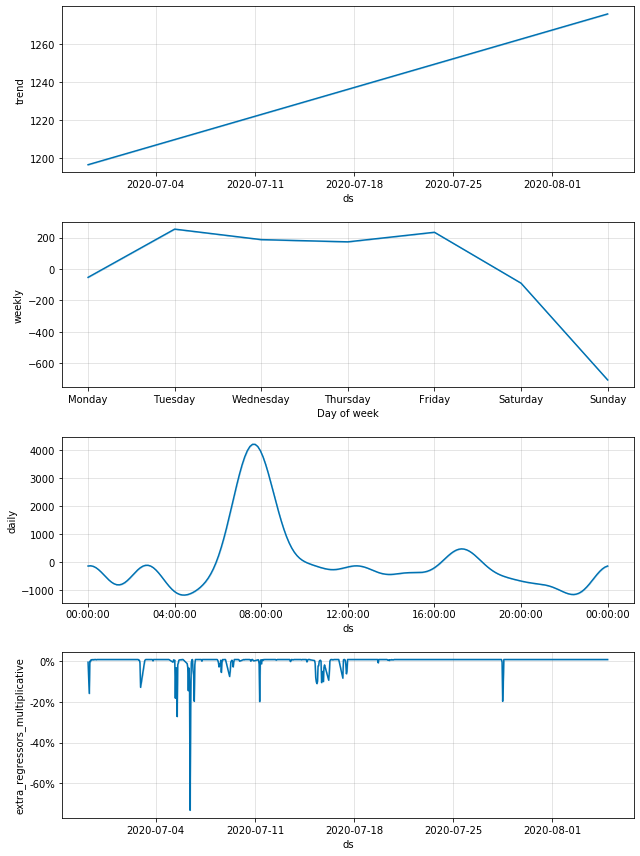

In [20]:

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast,weekly_start=1)
#fig1.savefig(r'C:\Users\飘哥\Desktop\fig1.jpg',dpi=1000)
#fig2.savefig(r'C:\Users\飘哥\Desktop\fig2.jpg',dpi=1000)

In [166]:
#不拆分训练和预测直接进行交叉验证
m2= Prophet(changepoint_prior_scale=0.05,daily_seasonality=10,changepoint_range=0.8,seasonality_mode='additive')
#m.add_country_holidays(country_name='CN')
m2.add_regressor('rain',prior_scale=0.5, mode='multiplicative')
m2.fit(data2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [183]:
#交叉验证
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m2, initial='300 hours', period='63 hours', horizon = '126 hours')
df_cv


INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-07-14 04:00:00 and 2020-07-24 16:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-14 05:00:00,436.564748,-443.735370,1282.209992,245,2020-07-14 04:00:00
1,2020-07-14 06:00:00,1644.012291,759.471457,2495.627218,1671,2020-07-14 04:00:00
2,2020-07-14 07:00:00,4524.402789,3710.447027,5395.868492,5751,2020-07-14 04:00:00
3,2020-07-14 08:00:00,5329.228537,4422.034678,6161.944867,6452,2020-07-14 04:00:00
4,2020-07-14 09:00:00,2684.652672,1867.012416,3450.959703,2962,2020-07-14 04:00:00
...,...,...,...,...,...,...
469,2020-07-29 18:00:00,1639.075174,832.556451,2434.193514,1655,2020-07-24 16:00:00
470,2020-07-29 19:00:00,1012.478289,240.720971,1824.409960,859,2020-07-24 16:00:00
471,2020-07-29 20:00:00,782.608330,-1.253944,1586.526287,624,2020-07-24 16:00:00
472,2020-07-29 21:00:00,649.074744,-129.584245,1495.136511,454,2020-07-24 16:00:00


In [184]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 13:00:00,193212.858347,439.559846,321.451526,0.322064,0.211873,0.914894
1,0 days 14:00:00,188376.934343,434.024117,315.141978,0.305860,0.211873,0.914894
2,0 days 15:00:00,318990.116616,564.792100,351.000339,0.321627,0.197679,0.904255
3,0 days 16:00:00,466711.442478,683.162823,377.793355,0.324649,0.197679,0.904255
4,0 days 17:00:00,447534.202033,668.979971,356.788538,0.309134,0.192190,0.914894
...,...,...,...,...,...,...,...
109,5 days 02:00:00,163449.295657,404.288629,300.030868,0.425648,0.180091,0.914894
110,5 days 03:00:00,320359.657586,566.003231,344.107938,0.507246,0.196308,0.904255
111,5 days 04:00:00,504236.578375,710.096175,373.234902,0.533390,0.224467,0.904255
112,5 days 05:00:00,484769.988579,696.254256,354.429471,0.511352,0.224467,0.914894


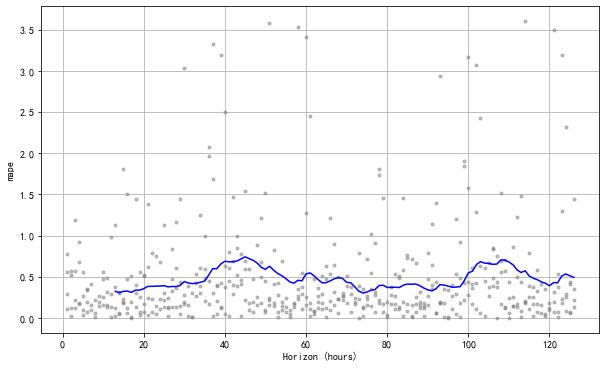

In [185]:
# 交叉验证性能指标,随预测时间的mape变化,横坐标是horizon
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [186]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper',
       'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'rain',
       'rain_lower', 'rain_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yhat'],
      dtype='object')

In [598]:
#forecast[['ds', 'trend', 'daily', 'weekly','extra_regressors_multiplicative','yhat']]
#forecast[['ds', 'trend', 'daily', 'weekly','extra_regressors_additive','yhat']]
forecast[['ds', 'trend', 'daily', 'rain','weekly','extra_regressors_multiplicative','Mid-Autumn Festival']].to_csv(r'C:\Users\飘哥\Desktop\forecast5.csv')

In [15]:
import fbprophet
import pycurl
import sklearn
help(fbprophet.diagnostics)
#help(sklearn.model_selection.cross_val_score)

Help on module fbprophet.diagnostics in fbprophet:

NAME
    fbprophet.diagnostics

DESCRIPTION
    # -*- coding: utf-8 -*-
    # Copyright (c) Facebook, Inc. and its affiliates.

FUNCTIONS
    coverage(df, w)
        Coverage
        
        Parameters
        ----------
        df: Cross-validation results dataframe.
        w: Aggregation window size.
        
        Returns
        -------
        Dataframe with columns horizon and coverage.
    
    cross_validation(model, horizon, period=None, initial=None)
        Cross-Validation for time series.
        
        Computes forecasts from historical cutoff points. Beginning from
        (end - horizon), works backwards making cutoffs with a spacing of period
        until initial is reached.
        
        When period is equal to the time interval of the data, this is the
        technique described in https://robjhyndman.com/hyndsight/tscv/ .
        
        Parameters
        ----------
        model: Prophet class object.

In [ ]:
# 将2015年前半年的数据设为缺失
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
m.plot(m.predict(future));
